<a href="https://colab.research.google.com/github/comatan96/SMO/blob/master/ex13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Callable
from datetime import datetime

$\overset{maximize}\alpha -\frac{1}{2}\cdot \sum_{i=1}^{N} \sum_{j=1}^{N} y_i y_j K(\mathbf{x}_i, \mathbf{x}_j)\alpha_i\alpha_j$ $+$ $\sum_{i=1}^{N} \alpha_i$

# Part A
* I chose to use the heuristics under section $2.2$ of the paper
     > If E1 is positive, SMO chooses an example with minimum error E2. If E1 is negative, SMO chooses an example with maximum error E2.`
* The convergence criterion is just as described in the paper at the pseudo code
    > using `while (numChanged > 0 | examineAll)`
* the computence of the threshold $b$ is as the on on the paper at section $2.3$
    * $b_1 = E_1 + y_1(\alpha_1^{new}-\alpha_1)K(\vec{x_1},\vec{x_1})+y_2(\alpha_2^{new,clipped}-\alpha_2)K(\vec{x_1},\vec{x_1})+b$
    * $b_2 = E_2 + y_1(\alpha_1^{new}-\alpha_1)K(\vec{x_1},\vec{x_2})+y_2(\alpha_2^{new,clipped}-\alpha_2)K(\vec{x_2},\vec{x_2})+b$


## how to run the code
in order to use the SMO implementation simply create a new estimator with the following params:
* C - A penalty value for the SVM
* kernel - can be 'linear' or 'rbf' or 'RBF'
* gamma - gamma value if you chose Radial Basis Function kernel

Then you can fit your model on your data set
* X - which is a Dataframe or a numpy matrix (array)
* y - which is a pandas Series or a numpy array

example:

    est = SMO(C=10, kernel='rbf', gamma=1.4).fit(X_train, y_train)
    

In [79]:
class SMO:
    def __init__(self, C, kernel='linear', gamma=None):
        self._kernel = kernel.lower()
        self.gamma = gamma
        self.C = C
        self.b = 0
        self.kernel = self._kernel
        self.gamma = gamma
        self.__eps = 10e-3

    @property
    def kernel(self):
        return self.__kernel

    @kernel.setter
    def kernel(self, kernel):
        if kernel == 'linear':
            self.__kernel = self.__linear_kernel
        elif kernel == 'rbf':
            self.__kernel = self.__rbf
        elif isinstance(kernel, Callable):
            self.__kernel = kernel
        else:
            raise TypeError(f'{type(kernel)} must be "linear", "rbf" or a Callable kernel function')

    @property
    def gamma(self):
        return self.__gamma

    @gamma.setter
    def gamma(self, gamma):
        if self._kernel == 'rbf' and gamma:
            self.__gamma = gamma
        elif self._kernel == 'rbf':
            raise TypeError('Radial Basis Kernel must be set with gamma param')
        elif gamma:
            raise TypeError('Cannot use gamma param with Linear kernel')
        else:
            self.__gamma = None

    def __linear_kernel(self, x_1, x_2):
        return x_1 @ x_2.T

    def __rbf(self, x, y):
        if np.ndim(x) ==  np.ndim(y) == 1:
            norm = np.linalg.norm(x - y, 2)
        elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
            norm = np.linalg.norm(x - y, 2, axis=1)
        else:
            norm = np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2)
        return np.exp(-self.gamma * (norm ** 2))


    def __objective_function(self, alphas):
        y_mult = self.y[:, None] * self.y[None, :]
        K_x = self.kernel(self.X, self.X)
        alpha_mult = alphas[:, None] * alphas[None, :]
        return -0.5 * np.sum(y_mult * K_x * alpha_mult) + np.sum(alphas)

    def decision_function(self, X):
        return (self.alphas * self.y) @ self.kernel(self.X, X) - self.b

    @property
    def training_set_size(self):
        return len(self.X)

    def _clip(self, a_2, L, H):
        return L if a_2 < L else H if a_2 > H else a_2

    def _compute_a_2(self, i1, i2, alpha_2, y_2, E_1, E_2, eta, L, H):
        if eta > 0:
            a_2 = alpha_2 + y_2 * (E_1 - E_2) / eta
            a_2 = self._clip(a_2, L, H)
        else:
            _alphas = self.alphas.copy()
            # objective function at a2=L
            _alphas[i2] = L
            L_obj = self.__objective_function(_alphas)
            # objective function at a2=H
            _alphas[i2] = H
            H_obj = self.__objective_function(_alphas)
            a_2 = L if L_obj < (H_obj - self.__eps) else H if L_obj > (H_obj + self.__eps) else alpha_2
        return a_2

    def _compute_L_H(self, s, alpha_1, alpha_2):
        if s < 0:
            L = max(0, alpha_2 - alpha_1)
            H = min(self.C, self.C + alpha_2 - alpha_1)
        else:
            L = max(0, alpha_2 + alpha_1 - self.C)
            H = min(self.C, alpha_2 + alpha_1)
        return L, H

    def _update_error_cache(self, a_1, alpha_1, a_2, alpha_2, i1, i2, y_1, y_2, b):
        for i, a in zip((i1, i2), (a_1, a_2)):
            if 0 < a < self.C:
                self.errors[i] = 0
        self._update_non_optimized_errors(a_1, alpha_1, a_2, alpha_2, i1, i2, y_1, y_2, b)

    def _update_alpha_list(self, a_1, a_2, i1, i2):
        self.alphas[i1] = a_1
        self.alphas[i2] = a_2

    def _update_non_optimized_errors(self, a_1, alpha_1, a_2, alpha_2, i1, i2, y_1, y_2, b):
        non_optimized = [idx for idx in range(self.training_set_size) if idx not in [i1, i2]]
        a_1_optimization = y_1 * (a_1 - alpha_1) * self.kernel(self.X[i1], self.X[non_optimized])
        a_2_optimization = y_2 * (a_2 - alpha_2) * self.kernel(self.X[i2], self.X[non_optimized])
        b_optimization = self.b - b
        self.errors[non_optimized] = self.errors[non_optimized] + a_1_optimization + a_2_optimization + b_optimization

    def _second_choice_heuristic(self, E_1):
        return np.argmin(self.errors) if E_1 > 0 else np.argmax(self.errors)

    def _take_step(self, i1, i2):
        # if chosen alphas are equal it means we need to skip
        if i1 == i2:
            return False
        alpha_1, alpha_2 = self.alphas[i1], self.alphas[i2]
        y_1, y_2 = self.y[i1], self.y[i2]
        E_1, E_2 = self.errors[i1], self.errors[i2]
        s = y_1 * y_2
        # compute L and H for clipping
        L, H = self._compute_L_H(s, alpha_1, alpha_2)
        # for equal upper and lower bound - skip
        if L == H:
            return False
        # get the values for the kernel function
        k11 = self.kernel(self.X[i1], self.X[i1])
        k12 = self.kernel(self.X[i1], self.X[i2])
        k22 = self.kernel(self.X[i2], self.X[i2])
        # compute eta
        eta = k11 + k22 - (2 * k12)
        a_2 = self._compute_a_2(i1, i2, alpha_2, y_2, E_1, E_2, eta, L, H)
        if abs(a_2 - alpha_2) < self.__eps * (a_2 + alpha_2 + self.__eps):
            return False
        a_1 = alpha_1 + s * (alpha_2 - a_2)
        # update threshold
        b1 = E_1 + y_1 * (a_1 - alpha_1) * k11 + y_2 * (a_2 - alpha_2) * k12 + self.b
        b2 = E_2 + y_1 * (a_1 - alpha_1) * k12 + y_2 * (a_2 - alpha_2) * k22 + self.b
        b_halfway = abs(b1 + b2) / 2
        b = b1 if 0 < a_1 < self.C else b2 if 0 < a_2 < self.C else b_halfway
        self._update_alpha_list(a_1, a_2, i1, i2)
        self._update_error_cache(a_1, alpha_1, a_2, alpha_2, i1, i2, y_1, y_2, b)
        self.b = b
        return True

    def _examine_example(self, i2):
        y_2 = self.y[i2]
        alpha_2 = self.alphas[i2]
        E_2 = self.errors[i2]
        r_2 = E_2 * y_2
        tol = 10e-3
        if (r_2 < -tol and alpha_2 < self.C) or (r_2 > tol and alpha_2 > 0):
            # number of non-zero & non-C alpha > 1
            condition = (self.alphas != 0) & (self.alphas != self.C)
            if len(self.alphas[condition]) > 1:
                # second choice heuristic
                i1 = self._second_choice_heuristic(E_2)
                if self._take_step(i1, i2):
                    return 1
            for i1 in np.roll(np.where(condition)[0], np.random.choice(np.arange(self.training_set_size))):
                step_result = self._take_step(i1, i2)
                if step_result:
                    return 1
            # if take step didn't succeed, loop over all alphas and try again
            for i1 in np.roll(np.arange(self.training_set_size), np.random.choice(self.training_set_size)):
                step = self._take_step(i1, i2)
                if step:
                    return 1
        return 0

    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy(copy=True)
        if isinstance(y, pd.core.series.Series):
            y = y.to_numpy(copy=True)
        self.X, self.y = X, y
        self.alphas = np.zeros(len(self.X))
        self.errors = self.decision_function(X) - self.y
        num_changed = 0
        examine_all = True
        while num_changed > 0 or examine_all:
            num_changed = 0
            non_zeros_non_c = np.where((self.alphas != 0) & (self.alphas != self.C))[0]
            alphas = range(self.alphas.shape[0]) if examine_all else non_zeros_non_c
            for i in alphas:
                num_changed += self._examine_example(i)
            if examine_all:
                examine_all = False
            elif not num_changed:
                examine_all = True
        return self

    def get_params(self, deep=False):
        pass

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy(copy=True)
        return np.sign(self.decision_function(X))

    def score(self, X, y):
        return sum(y1 == y2 for y1, y2 in zip(y, self.predict(X))) / y.shape[0]

# Example for running my SMO algorithm

In [80]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=1)
# change labels to +1/-1
y[y == 0] = -1
# standard scaler in order to fix variance
X = StandardScaler().fit_transform(X, y)
model = SMO(C=1, kernel='RBF', gamma=1).fit(X, y)

# Part B

In [4]:
from sklearn import datasets
import pandas as pd
import seaborn as sns
sns.set_theme(style='ticks')
iris = datasets.load_iris(as_frame=True)
df = iris.frame


## (a) We can clearly see that the sctter matrix (pairplot) determining between class 0 and 1, 2

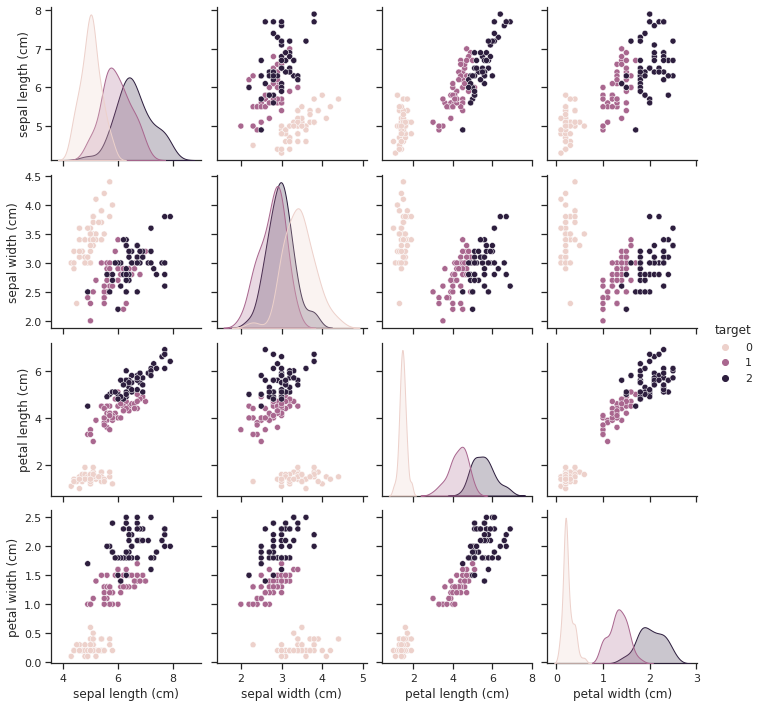

In [5]:
sns.pairplot(df, hue='target')

## (b)

Create data set for train and test

In [83]:
from sklearn.model_selection import train_test_split
X = df[iris.feature_names]
y = df.target

Linear SVM grid search + one_vs_all_classifier + train test split

In [89]:
def linear_svm_grid_search(X_train, y_train, X_val, y_val, grid, one, rest):
    """ Grid search over C param for the linear SVM """
    best_clf, best_c, best_score = None, 0, 0
    for C in grid['C']:
        svm = SMO(C=C).fit(X_train, y_train)
        score = svm.score(X_val, y_val)
        if score >= best_score:
            best_clf, best_c, best_score = svm, C, score
    print(f'Found optimal C={best_c} for set {one} vs {rest}, validation score: {best_score:.2f}')
    return best_clf

def create_ova(y_train, y_val, one, rest):
    """ create data set for the OVA/OVR """
    for v in rest:
        y_train, y_val = y_train.replace(v, -1), y_val.replace(v, -1)
    y_train, y_val = y_train.replace(one, 1), y_val.replace(one, 1)
    return y_train, y_val

def one_vs_all_classifier(X, y, grid):
    # create data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25)
    # create set of the labels
    all_ys = set(y.values)
    clfs = []
    # create OVA/OVR sets and get the best classifier by grid search over C
    for one in all_ys:
        rest = all_ys - {one}
        # create OVR sets
        _y_train, _y_val = create_ova(y_train, y_val, one, rest)
        # use grid search
        clfs.append(linear_svm_grid_search(X_train, _y_train, X_val, _y_val, grid, one, rest))
    return clfs, X_test, y_test

get the best estimators

In [107]:
linear_grid_params = {'C': [0.1, 1, 10, 100, 1000, 10000]}
clfs, X_test, y_test = one_vs_all_classifier(X, y, linear_grid_params)

Found optimal C=10000 for set 0 vs {1, 2}, validation score: 1.00
Found optimal C=10000 for set 1 vs {0, 2}, validation score: 0.70
Found optimal C=10 for set 2 vs {0, 1}, validation score: 0.97


## (c)

In [108]:
def ova_predict(clfs, X_test, y_test):
    """ For each sample in the test set get the maximum value from each
    classfire of the 3, this is the most 'confident' estimator, thus it is
    the prediction from the OVA clssifire.
    return - array of predictions of the test set
    """
    predictions = []
    for x in X_test.to_numpy():
        classifires_and_predictions = [
            (i, clf.decision_function(x))
            for i, clf
            in enumerate(clfs)
        ]
        predictions.append(max(classifires_and_predictions, key=lambda p: p[1])[0])
    return np.array(predictions)

y_pred = ova_predict(clfs, X_test, y_test)

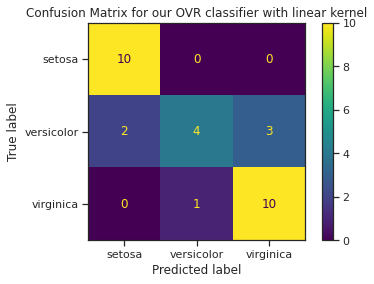

In [109]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
labels = ['setosa', 'versicolor', 'virginica']
acc = lambda cm: np.sum(cm.diagonal()) / np.sum(cm)
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot()
plt.title('Confusion Matrix for our OVR classifier with linear kernel')
plt.show()

In [110]:
print(f'Model accuracy: {acc(cm)}')

Model accuracy: 0.8


As we can see, the results are as expected.
* The score on the validation set for each class:
    * for the first class is 1
    * for the second class is 0.70
    * for the third class is 0.97

**The scores aren't surprising as we can see:**
* The first class is separated from the other two, which explains the score of 1 over the validation set.
* The second set is "in between" the other two - which explains the lowest score over the validation set.
* The third set is on the other side and it seems like we can seperate it with a "softer" margin than the other sets (C=10)

the accuracy is $0.8$, which is good altough two of the classes are not linearly separable.


## (d)

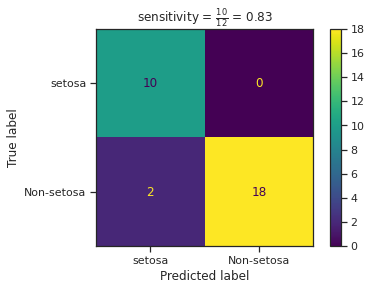

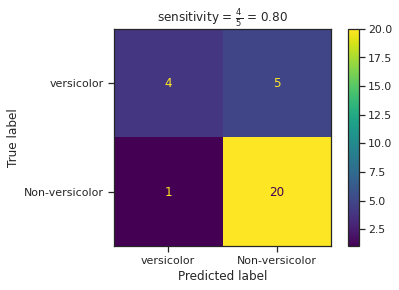

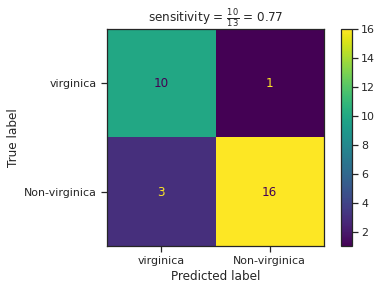

In [111]:
from sklearn.metrics import multilabel_confusion_matrix
tables_of_confusion = list(map(lambda toc: np.rot90(toc, 2), multilabel_confusion_matrix(y_test, y_pred)))
for label, toc in zip(labels, tables_of_confusion):
    table = ConfusionMatrixDisplay(toc, display_labels=[label, f'Non-{label}'])
    TP, FN = toc[0:,0]
    table.plot()
    plt.title(f'sensitivity = $\\frac{{{TP}}}{{{TP + FN}}}$ = ${TP/(TP+FN):.2f}$')
    plt.show()

As we can see the results show that the sensitivies are:
* $0.83$ for the setos
* $0.80$ for the versicolor
* $0.77$ for the virginica

All of the sensitivites are around $0.8$ 

This implies that the portion of samples that were predicted well is large corresponding to the entire samples.

It also implies that the accuracy of our model is not as affected by the lack of balance in our dataset as we thought it would be.

## (e)

In [114]:
from itertools import product
def rbf_svm_grid_search(X_train, y_train, X_val, y_val, grid, one, rest):
    """ Grid search over C param for the linear SVM """
    best_clf, best_c, best_gamma, best_score = None, 0, 0, 0
    for C, gamma in product(*grid.values()):
        svm = SMO(C=C, kernel='rbf', gamma=gamma).fit(X_train, y_train)
        score = svm.score(X_val, y_val)
        if score >= best_score:
            best_clf, best_c, best_gamma, best_score = svm, C, gamma, score
    print(f'Found optimal C={best_c}, gamma={best_gamma} for set {one} vs {rest}, validation score: {best_score:.2f}')
    return best_clf

def one_vs_all_rbf_classifier(X, y, grid):
    # create data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25)
    # create set of the labels
    all_ys = set(y.values)
    clfs = []
    # create OVA/OVR sets and get the best classifier by grid search over C
    for one in all_ys:
        rest = all_ys - {one}
        # create OVR sets
        _y_train, _y_val = create_ova(y_train, y_val, one, rest)
        # use grid search
        clfs.append(rbf_svm_grid_search(X_train, _y_train, X_val, _y_val, grid, one, rest))
    return clfs, X_test, y_test

rbf_grid = {
    'C': [0.1, 1, 10, 100, 1000, 10000],
    'gamma': [0.01, 0.1, 0.5, 1, 1.5, 2, 3]
}
rbf_clfs, rbf_X_test, rbf_y_test = one_vs_all_rbf_classifier(X, y, rbf_grid)

Found optimal C=10000, gamma=3 for set 0 vs {1, 2}, validation score: 1.00
Found optimal C=100, gamma=0.01 for set 1 vs {0, 2}, validation score: 0.97
Found optimal C=1000, gamma=1 for set 2 vs {0, 1}, validation score: 0.97


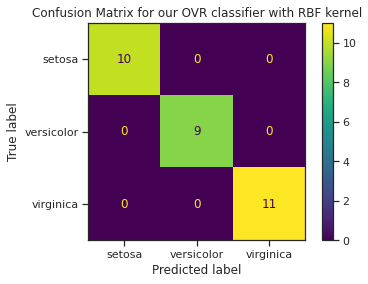

In [115]:
rbf_y_pred = ova_predict(rbf_clfs, rbf_X_test, rbf_y_test)
rbf_cm = confusion_matrix(rbf_y_test, rbf_y_pred)
rbf_cmd = ConfusionMatrixDisplay(rbf_cm, display_labels=labels)
rbf_cmd.plot()
plt.title('Confusion Matrix for our OVR classifier with RBF kernel')
plt.show()

In [116]:
print(f'Model accuracy with RBF kernel: {acc(rbf_cm)}')

Model accuracy with RBF kernel: 1.0


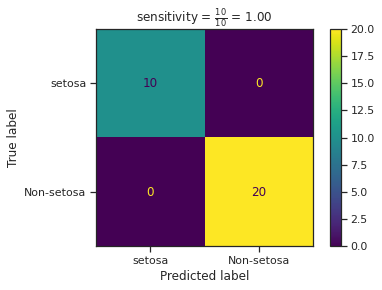

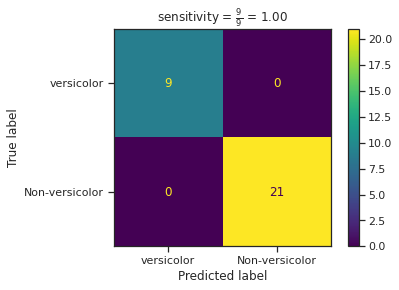

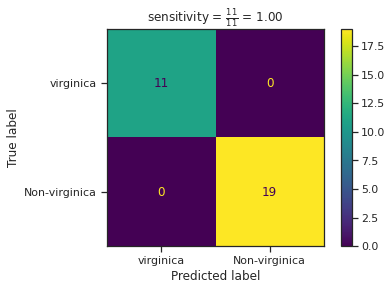

In [117]:
rbf_tables_of_confusion = list(map(lambda toc: np.rot90(toc, 2), multilabel_confusion_matrix(rbf_y_test, rbf_y_pred)))
for label, toc in zip(labels, rbf_tables_of_confusion):
    table = ConfusionMatrixDisplay(toc, display_labels=[label, f'Non-{label}'])
    TP, FN = toc[0:,0]
    table.plot()
    plt.title(f'sensitivity = $\\frac{{{TP}}}{{{TP + FN}}}$ = ${TP/(TP+FN):.2f}$')
    plt.show()

# Comparison between linear kernel and gaussian RBF kernel

|                         | linear kernel | gaussian RBF kernel |
|-------------------------|---------------|---------------------|
| validation set accuracy | 1/0.7/0.97    | 1/0.97/0.97         |
| test set accuracy       | 0.8           | 1                   |
| runtime for grid search | 8s            | 1m                  |

we can see the the RBF kernel is not struggling with the separability of the data set, and this is obviously because of the way it works.

The tradeoff is within the grid search, which took up to a minute with the RBF kernel because I had to use a cross pruduct between the C's and the Gamma's.
